# Disaster Tweet project

In [1]:
!pip install tensorflow -q

In [2]:
!pip install spacy -q

### Import libraries

In [35]:
import pandas as pd
import numpy as np
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM

### Usual EDA

In [4]:
data = pd.read_csv("Disaster_Tweets_Train.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [118]:
data.iloc[2222,1]

'deluged'

In [5]:
# check if the target is balanced
data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# check on missing values
data["keyword"].isna().value_counts()

False    7552
True       61
Name: keyword, dtype: int64

In [7]:
# check on missing values
data["location"].isna().value_counts()

False    5080
True     2533
Name: location, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
data = data.fillna('')
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


### Word Embedding : preprocessings

In [10]:
!python -m spacy download en_core_web_sm -q

2022-03-01 08:09:01.843065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 08:09:01.843107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

In [12]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

##### Define function to clean text :

- Remove non-alphanumeric characters
- lower characters
- lemmatize words and remove stop words
- Remove digits and replace with space
- Remove one-character-long "words"

note = some tweets contain urls starting with "http". I tried removing them, but it seemed to negatively impact the performance of models that's why I silenced this command.

In [270]:
#Define function to clean text :

pattern = r'[0-9]'
prefixes = "http"
def clean_text(text):
  text = "".join([ch for ch in text if ch.isalnum() or ch == " "])
  text = re.sub(" +", " ", text).lower().strip()
  text = " ".join([token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS and token.lemma_ not in STOP_WORDS])
  #text = " ".join([x for x in text.split() if not x.startswith(prefixes)])
  text = re.sub(pattern, ' ', text)
  text = ' '.join( [w for w in text.split() if len(w)>1] )

  return text

##### Clean features

note : I chose not to use the location as a feature

In [ ]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x))
data["keyword_clean"] = data["keyword"].astype(str).apply(lambda x: clean_text(x)+" ")

In [358]:
data["all_text_clean"] = +data["keyword_clean"] + data["text_clean"]

##### Encoding text

In [359]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000) # instanciate the tokenizer
tokenizer.fit_on_texts(data.all_text_clean)
data["all_text_encoded"] = tokenizer.texts_to_sequences(data.all_text_clean)

data["len"] = data["all_text_encoded"].apply(lambda x: len(x))
data = data[data["len"]!=0]

In [360]:
data.head()

,id,keyword,location,text,target,text_clean,keyword_clean,location_clean,all_text_clean,all_text_encoded,len
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,,,deed reason earthquake allah forgive,"[441, 97, 1384, 1961]",4
1,4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,,,forest fire near la ronge sask canada,"[68, 2, 257, 488, 1031]",5
2,5,,,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,,,resident ask shelter place notify officer eva...,"[1385, 470, 1712, 380, 364, 101, 1712, 380, 35...",10
3,6,,,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,,,people receive wildfire evacuation order cali...,"[19, 73, 101, 356, 69]",5
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfires pou...,,,got send photo ruby alaska smoke wildfires po...,"[288, 281, 211, 1713, 102, 180]",6


#### Padding vectors

In [361]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data.all_text_encoded, padding="post")

In [362]:
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, data.target))

#### Train/Test split

In [364]:
# Train Test Split
TAKE_SIZE = int(0.7*data.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [365]:
 # Regardons un batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[  13   24  174 ...    0    0    0]
 [  11 1653   11 ...    0    0    0]
 [   6   10 1441 ...    0    0    0]
 ...
 [   2  882  324 ...    0    0    0]
 [  86  771 1287 ...    0    0    0]
 [  30  397   30 ...    0    0    0]], shape=(64, 18), dtype=int32) tf.Tensor(
[1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0], shape=(64,), dtype=int64)


## Model 1 : With word embbeding

In [366]:
vocab_size = 2000
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 16, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [367]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 global_average_pooling1d_10  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_82 (Dense)            (None, 16)                272       
                                                                 
 dense_83 (Dense)            (None, 8)                 136       
                                                                 
 dense_84 (Dense)            (None, 1)                 9         
                                                                 
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
_________________________________________________

In [368]:
optimizer= tf.keras.optimizers.Adam(0.0002)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [369]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data)

Epoch 1/20
82/82 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5718 - val_loss: 0.6902 - val_accuracy: 0.5539
Epoch 2/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5722 - val_loss: 0.6875 - val_accuracy: 0.5539
Epoch 3/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5724 - val_loss: 0.6839 - val_accuracy: 0.5539
Epoch 4/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5735 - val_loss: 0.6776 - val_accuracy: 0.5548
Epoch 5/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.5893 - val_loss: 0.6673 - val_accuracy: 0.5686
Epoch 6/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6195 - val_loss: 0.6556 - val_accuracy: 0.5890
Epoch 7/20
82/82 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6630 - val_loss: 0.6415 - val_accuracy: 0.6336
Epoch 8/20
82/82 [==

##

### Evaluation Model 1

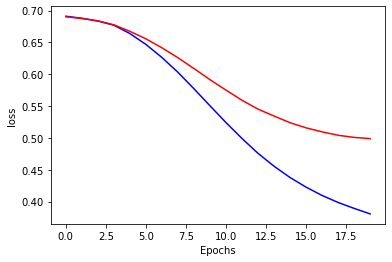

In [370]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

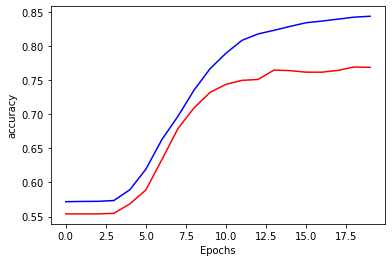

In [371]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

## Model 2 : with RNN

In [372]:
vocab_size = 2000
embedding_dim=16 # the dimensionality of the representation space

model_rnn = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[tweet.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  SimpleRNN(units=64, return_sequences=True, kernel_regularizer = "l1"), # maintains the sequential nature
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

In [373]:
model_rnn.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 18, 64)            5184      
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_85 (Dense)            (None, 16)                528       
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 40,849
Trainable params: 40,849
Non-trainable params: 0
_________________________________________________________________


In [374]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [375]:
history_rnn = model_rnn.fit(
    train_data,
    validation_data=test_data,
    epochs=10)

Epoch 1/10
82/82 [==============================] - 3s 19ms/step - loss: 2.0260 - accuracy: 0.5533 - val_loss: 1.9800 - val_accuracy: 0.5650
Epoch 2/10
82/82 [==============================] - 1s 15ms/step - loss: 1.9082 - accuracy: 0.6333 - val_loss: 1.8716 - val_accuracy: 0.6331
Epoch 3/10
82/82 [==============================] - 1s 14ms/step - loss: 1.7781 - accuracy: 0.7064 - val_loss: 1.7840 - val_accuracy: 0.6416
Epoch 4/10
82/82 [==============================] - 1s 15ms/step - loss: 1.6422 - accuracy: 0.7606 - val_loss: 1.7074 - val_accuracy: 0.6652
Epoch 5/10
82/82 [==============================] - 1s 15ms/step - loss: 1.5280 - accuracy: 0.7936 - val_loss: 1.6346 - val_accuracy: 0.6817
Epoch 6/10
82/82 [==============================] - 1s 14ms/step - loss: 1.4278 - accuracy: 0.8194 - val_loss: 1.5879 - val_accuracy: 0.6874
Epoch 7/10
82/82 [==============================] - 1s 16ms/step - loss: 1.3409 - accuracy: 0.8372 - val_loss: 1.5430 - val_accuracy: 0.6888
Epoch 8/10
82

##

### evaluation Model 2

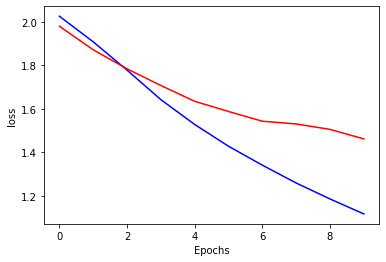

In [376]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history_rnn.history["loss"], color="b")
plt.plot(history_rnn.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

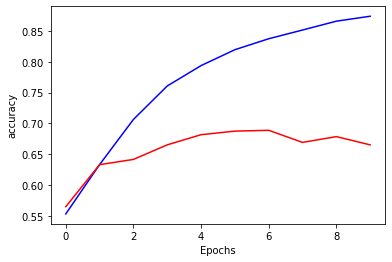

In [377]:
# Visualization of accuracy training 
plt.plot(history_rnn.history["accuracy"], color="b")
plt.plot(history_rnn.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

## Model 3 : with LSTM

In [378]:
vocab_size = 2000
embedding_dim=16 # the dimensionality of the representation space

model_lstm = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[tweet.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

In [379]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(0.00002),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [380]:
model_lstm.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 bidirectional_11 (Bidirecti  (None, 18, 128)          41472     
 onal)                                                           
                                                                 
 lstm_29 (LSTM)              (None, 32)                20608     
                                                                 
 dense_87 (Dense)            (None, 16)                528       
                                                                 
 dense_88 (Dense)            (None, 1)                 17        
                                                                 
Total params: 94,641
Trainable params: 94,641
Non-trainable params: 0
_________________________________________________

In [381]:
history_lstm = model_lstm.fit(
    train_data,
    validation_data=test_data,
    epochs=20)

Epoch 1/20
82/82 [==============================] - 10s 51ms/step - loss: 0.6920 - accuracy: 0.5722 - val_loss: 0.6915 - val_accuracy: 0.5539
Epoch 2/20
82/82 [==============================] - 3s 37ms/step - loss: 0.6903 - accuracy: 0.5722 - val_loss: 0.6902 - val_accuracy: 0.5539
Epoch 3/20
82/82 [==============================] - 3s 37ms/step - loss: 0.6885 - accuracy: 0.5722 - val_loss: 0.6887 - val_accuracy: 0.5539
Epoch 4/20
82/82 [==============================] - 3s 37ms/step - loss: 0.6863 - accuracy: 0.5722 - val_loss: 0.6868 - val_accuracy: 0.5539
Epoch 5/20
82/82 [==============================] - 3s 39ms/step - loss: 0.6834 - accuracy: 0.5722 - val_loss: 0.6844 - val_accuracy: 0.5539
Epoch 6/20
82/82 [==============================] - 3s 38ms/step - loss: 0.6800 - accuracy: 0.5722 - val_loss: 0.6821 - val_accuracy: 0.5539
Epoch 7/20
82/82 [==============================] - 3s 39ms/step - loss: 0.6764 - accuracy: 0.5722 - val_loss: 0.6798 - val_accuracy: 0.5539
Epoch 8/20
8

##

### evaluation Model 3

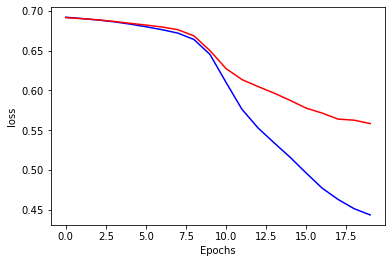

In [382]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

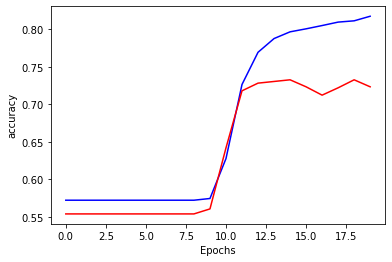

In [383]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

##

## Conclusion

#### Model 1 : conclusions

- Model 1 is the simpliest and it has relatively good performance after the preprocessings were tuned. Both loss and val loss decrease, it seems to not overfit, and the accuracy reaches about 0,75.
- Performance was improved with setting low learning rate

Analyse (below) of the texts shows that the worst predictions are linked with texts that are not easy to link to disasters as such, even for human intelligence.

#### Model 2 : conclusions

- Model 2 has simple RNN. The performance was never really good, it was overfitting very fast with default parameters. 
- I could limit overfitting with setting Ridge regularizer one the first RNN layer, and low learning rate.
- But the performance is not the best, with higher loss and lesser acuracy than model 1 & 3.

#### Model 3 : conclusions
- Model 3 is the more complex with LSTM and is a slow learner
- At first is was not performing very well and might overfit with default parameters.
- I had to set the learning rate very low (0, 00002), and rise the number of epochs : it does not learn anything before epoch N°10.
- Then after it has quick learning and reaches some good performance that could compare with model 1.
- However, for it is complex and slow, Model 1 should be prefered.

#### Demo : worst predictions with Model 1, compared to initial text and target

In [400]:
test_pred =model.predict(text_pad)
df_eval = pd.DataFrame({"pred":test_pred.squeeze(), "target":target, "text":data.text})
df_eval["mae"] = np.abs(df_eval["target"] - df_eval["pred"])
df_eval.sort_values(by= "mae" , ascending=False).reset_index().head(50)

,index,pred,target,text,mae
0,974,0.032584,1,?? New Ladies Shoulder Tote #Handbag Faux Leat...,0.967416
1,991,0.046318,1,@Yankees body bagging mfs,0.953682
2,789,0.047481,1,@todd_calfee so @mattburgener wanted to see th...,0.952519
3,1005,0.048036,1,'I did another one I did another one. You stil...,0.951964
4,753,0.048335,1,@BenKin97 @Mili_5499 remember when u were up l...,0.951665
5,2250,0.052167,1,Why are you deluged with low self-image? Take ...,0.947833
6,1908,0.052996,1,So many Youtube commenters saying the Dothraki...,0.947004
7,1853,0.053278,1,Ina Buted Girl Crush??,0.946722
8,1014,0.053587,1,ÛÏ@MacDaddy_Leo: ?????? No Caption Needed ??....,0.946413
9,4917,0.056474,1,I liked a @YouTube video from @itsjustinstuart...,0.943526


## 

## Hypothetical Improvements 

- I could try to train a model with encoder/decoder and compare performance but I felt that adding more and more complexity here is not the best solution.
- It would help to have more data